# Single Family Parcels in the City of Los Angeles


For our group project, my team is researching the potential impact that SB8, SB9, and SB10 can make on the supply of affordable housing in the City of Los Angeles. One of our primary data sources will highlight existing single-famiy zoning conditions in the City of Los Angeles. This data source will highlight areas in which ADUs and smallplexes are permitted to be constructed. The zoning information for the City of Los Angeles can be found [here](https://geohub.lacity.org/datasets/zoning/explore?location=34.055956%2C-118.234564%2C12.90). 

Thus, in this notebook,we will be filtering the zoning information of the City of Los Angeles and running a spatial autocorrelation analysis to understand which neighborhoods in Los Angeles have the highest percentage/concentration of single family zones. We will use the LA Times neighborhood boundary as our location index. 

## 1. Importing Data

In [1]:
# to read and wrangle data
import pandas as pd

# to import data from LA Data portal
from sodapy import Socrata

# to create spatial data
import geopandas as gpd

# for basemaps
import contextily as ctx

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
#lets import our data
gdf = gpd.read_file('Data/LA_Zoning.json')

## 2. Preliminary Exploration

I want to get an idea of what my data looks like. We will look at shape to see the number of rows and columns available to us, type to make sure mapshaper did not convert our geopanda file into something else, and head to get a better look at what data is available to us.

In [3]:
#number of rows and columns 
gdf.shape

(58663, 7)

We have 58663 rows and 7 columms. 

In [4]:
# double checking to make sure mapshaper did not change the data type
type(gdf)

geopandas.geodataframe.GeoDataFrame

Geopandas! We're good to go. 

In [5]:
# what does my data table look like?
gdf.head()

,OBJECTID,ZONE_CMPLT,ZONE_CLASS,ZONE_SMRY,SHAPE_Length,SHAPE_Area,geometry
0,1,(F)CM-1-CUGU,CM,INDUSTRIAL,0.001376,1.135955e-07,"POLYGON ((-118.38794 34.22863, -118.38794 34.2..."
1,2,(F)CM-1-CUGU,CM,INDUSTRIAL,0.001376,1.136063e-07,"POLYGON ((-118.38794 34.22959, -118.38795 34.2..."
2,3,(F)CM-1-CUGU,CM,INDUSTRIAL,0.001102,5.680651e-08,"POLYGON ((-118.38795 34.23014, -118.38795 34.2..."
3,4,(F)CM-1-CUGU,CM,INDUSTRIAL,0.001102,5.680455e-08,"POLYGON ((-118.38795 34.23041, -118.38795 34.2..."
4,5,(F)CM-1-CUGU,CM,INDUSTRIAL,0.001376,1.136150e-07,"POLYGON ((-118.38795 34.23140, -118.38796 34.2..."


Okay it looks like we have an object ID column followed by three different categorization categories, two shape/float columns, and a geometry/location column. 

In [6]:
# here is a summary of the information we just looked at
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 58663 entries, 0 to 58662
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   OBJECTID      58663 non-null  int64   
 1   ZONE_CMPLT    58663 non-null  object  
 2   ZONE_CLASS    58663 non-null  object  
 3   ZONE_SMRY     58537 non-null  object  
 4   SHAPE_Length  58663 non-null  float64 
 5   SHAPE_Area    58663 non-null  float64 
 6   geometry      58663 non-null  geometry
dtypes: float64(2), geometry(1), int64(1), object(3)
memory usage: 3.1+ MB


Now that we know what our data looks like, we can start analyzing our data

## 3. Data Values

I want to look at the value options/counts in our object columns.

### Zoning Summary 

In [7]:
gdf['ZONE_SMRY'].value_counts()

RESIDENTIAL        36534
COMMERCIAL         11095
INDUSTRIAL          3663
AGRICULTURE         2445
PUBLIC FACILITY     2100
OPEN SPACE          1451
PARKING             1249
Name: ZONE_SMRY, dtype: int64

Okay, so this column let's me know what land use type each zone has. I know that I want to look at the residential zones, so this could be useful.

### Zone Class

In the LA, the zone class is defined as: *the types of uses that are permitted on a property, including regulations related to building setbacks and minimum lot size requirements.* Let's take a look at the zone classes in this data set.

In [8]:
gdf['ZONE_CLASS'].value_counts()

R1        12768
C2         8023
R3         5045
RD1.5      3370
R2         3329
          ...  
PVSP          1
M2(PV)        1
USC-1A        1
CCS           1
A2P           1
Name: ZONE_CLASS, Length: 111, dtype: int64

Now this column tells me the actual zoning classification of the parcel. Downside, there are 111 unique values in this column. Upside, I only need the single family zone classes, so I won't really need to look into all 111 unique classifications. However, I might want to look at all the different classifications within the residential land use parcels.

### Zoning Code

By looking at the data table generated above, I can tell that the `ZONE_CMPLT` is giving us the complete zoning code for zone. The complete code gives us extra information like how tall a building on a property can be or if the parcel fall in a planning overlay districts. Let's take a look at how many unique values we have. 

In [9]:
gdf['ZONE_CMPLT'].value_counts()

R1-1           7914
RS-1           2442
R3-1           2383
R2-1           1713
C2-1VL-CPIO    1377
               ... 
[Q]A2-1           1
R1-1-K-RFA        1
(T)RS-1-K         1
(Q)RD4-1XL        1
A2P-1             1
Name: ZONE_CMPLT, Length: 1941, dtype: int64

There are 1941 unique values which is a lot. For the purposes of our research, we don't really need to know the entire zoning code of each parcel. All we need to know is the actual zone class. Thus, I can somewhat ignore this column. I won't delete it just yet because I may find use for it in the future.  

## 4. Filtering Data

### Residential Land Use 

I want to start off by filtering for the residential land use parcels only. This will help me trim the number of zone classes I can use.

In [10]:
gdf.query("ZONE_SMRY == 'RESIDENTIAL'")

,OBJECTID,ZONE_CMPLT,ZONE_CLASS,ZONE_SMRY,SHAPE_Length,SHAPE_Area,geometry
10,11,(F)R2-1-RIO,R2,RESIDENTIAL,0.003084,5.452941e-07,"POLYGON ((-118.48039 34.19086, -118.47940 34.1..."
11,12,(F)R2-1-RIO,R2,RESIDENTIAL,0.002809,3.635111e-07,"POLYGON ((-118.47939 34.19182, -118.47940 34.1..."
12,13,(F)R2-1-RIO,R2,RESIDENTIAL,0.003358,6.816327e-07,"POLYGON ((-118.47940 34.19265, -118.47940 34.1..."
13,14,(F)RE11-1,RE11,RESIDENTIAL,0.002197,2.039770e-07,"POLYGON ((-118.46579 34.32016, -118.46516 34.3..."
14,15,(F)RE11-1,RE11,RESIDENTIAL,0.002240,2.223388e-07,"POLYGON ((-118.46643 34.32065, -118.46579 34.3..."
...,...,...,...,...,...,...,...
58575,58576,[Q]R1-1D,R1,RESIDENTIAL,0.011773,2.462393e-06,"POLYGON ((-118.19818 34.07555, -118.19818 34.0..."
58576,58577,R1-1,R1,RESIDENTIAL,0.007004,1.775233e-06,"POLYGON ((-118.44049 34.20476, -118.44110 34.2..."
58581,58582,(T)R1-1,R1,RESIDENTIAL,0.002036,2.272604e-07,"POLYGON ((-118.52513 34.22788, -118.52513 34.2..."
58582,58583,(T)(Q)RD3-1,RD3,RESIDENTIAL,0.002211,2.155164e-07,"POLYGON ((-118.45261 34.23747, -118.45261 34.2..."


Now we have all the residential zones. This reduced our dataset from 58663 to 36534 rows. 

Let's define this query as *residential*

In [11]:
residential = gdf.query("ZONE_SMRY == 'RESIDENTIAL'").copy()
residential

,OBJECTID,ZONE_CMPLT,ZONE_CLASS,ZONE_SMRY,SHAPE_Length,SHAPE_Area,geometry
10,11,(F)R2-1-RIO,R2,RESIDENTIAL,0.003084,5.452941e-07,"POLYGON ((-118.48039 34.19086, -118.47940 34.1..."
11,12,(F)R2-1-RIO,R2,RESIDENTIAL,0.002809,3.635111e-07,"POLYGON ((-118.47939 34.19182, -118.47940 34.1..."
12,13,(F)R2-1-RIO,R2,RESIDENTIAL,0.003358,6.816327e-07,"POLYGON ((-118.47940 34.19265, -118.47940 34.1..."
13,14,(F)RE11-1,RE11,RESIDENTIAL,0.002197,2.039770e-07,"POLYGON ((-118.46579 34.32016, -118.46516 34.3..."
14,15,(F)RE11-1,RE11,RESIDENTIAL,0.002240,2.223388e-07,"POLYGON ((-118.46643 34.32065, -118.46579 34.3..."
...,...,...,...,...,...,...,...
58575,58576,[Q]R1-1D,R1,RESIDENTIAL,0.011773,2.462393e-06,"POLYGON ((-118.19818 34.07555, -118.19818 34.0..."
58576,58577,R1-1,R1,RESIDENTIAL,0.007004,1.775233e-06,"POLYGON ((-118.44049 34.20476, -118.44110 34.2..."
58581,58582,(T)R1-1,R1,RESIDENTIAL,0.002036,2.272604e-07,"POLYGON ((-118.52513 34.22788, -118.52513 34.2..."
58582,58583,(T)(Q)RD3-1,RD3,RESIDENTIAL,0.002211,2.155164e-07,"POLYGON ((-118.45261 34.23747, -118.45261 34.2..."


Now that I have filtered for residential land use, I can take a look at the residential zone classes to find the ones that apply to single family residential lots. 

In [12]:
residential['ZONE_CLASS'].value_counts()

R1          12768
R3           5045
RD1.5        3370
R2           3329
RS           2851
RD2          2079
R4           1265
RE11         1217
R1V2          824
RE15          760
RD3           702
RE40          417
RE9           304
RE20          278
R1R3          245
R5            140
RAS4          139
RD6           119
R1V3          116
RD5            92
R1V1           69
RD4            67
R1H1           47
RAS3           44
RW1            36
RMP            35
R3P            24
R4P            22
R1P            20
R4(PV)         20
RAS3(UV)       16
RZ3            12
R5P            11
RW2            10
RZ4             7
RZ5             7
R3(PV)          6
R3(UV)          6
RE              5
RZ2.5           5
R2P             2
RU              2
RSP             1
Name: ZONE_CLASS, dtype: int64

Now I can see exactly what the different zone class options for residntial land uses are. The single family zone classifications with the sufficient minimum rear yard setback requirement to build an ADU are: R1, RS, RU, R1V1, R1V2, RIV3, R1P, R1R3, R1H1, R1P, RW1, RE9, RE11, RE15, RE20, RE40. ([source](https://planning.lacity.org/odocument/eadcb225-a16b-4ce6-bc94-c915408c2b04/Zoning_Code_Summary.pdf)). I double checked our zone class values listed above to make sure the the codes match. They do! Thus, I want to filter my data for those parcels.


### Filtering for Single Family Zones

In [13]:
# I want to define a list of my filtered categories
filter_list = ['R1', 'RS', 'RU', 'R1V1', 'R1V2', 'RIV3', 'R1P', 'R1R3', 'R1H1', 'RW1', 'RE9', 'RE11', 'RE15', 'RE20', 'RE40']

In [14]:
#Now I filter my data for single family residential zones using my filtered zone classes.
gdf[gdf.ZONE_CLASS.isin(filter_list)]

,OBJECTID,ZONE_CMPLT,ZONE_CLASS,ZONE_SMRY,SHAPE_Length,SHAPE_Area,geometry
13,14,(F)RE11-1,RE11,RESIDENTIAL,0.002197,2.039770e-07,"POLYGON ((-118.46579 34.32016, -118.46516 34.3..."
14,15,(F)RE11-1,RE11,RESIDENTIAL,0.002240,2.223388e-07,"POLYGON ((-118.46643 34.32065, -118.46579 34.3..."
292,293,R1-1,R1,RESIDENTIAL,0.002181,2.471552e-07,"POLYGON ((-118.55781 34.20746, -118.55750 34.2..."
293,294,(Q)R1-1,R1,RESIDENTIAL,0.004872,6.329446e-07,"POLYGON ((-118.58963 34.22095, -118.58963 34.2..."
294,295,(Q)R1-1,R1,RESIDENTIAL,0.004019,3.750881e-07,"POLYGON ((-118.48842 34.22792, -118.48889 34.2..."
...,...,...,...,...,...,...,...
58572,58573,R1-1-CUGU,R1,RESIDENTIAL,0.002523,3.548346e-07,"POLYGON ((-118.36989 34.23047, -118.36924 34.2..."
58574,58575,[Q]RE20-1D,RE20,RESIDENTIAL,0.001126,2.483553e-08,"POLYGON ((-118.19818 34.07555, -118.19811 34.0..."
58575,58576,[Q]R1-1D,R1,RESIDENTIAL,0.011773,2.462393e-06,"POLYGON ((-118.19818 34.07555, -118.19818 34.0..."
58576,58577,R1-1,R1,RESIDENTIAL,0.007004,1.775233e-06,"POLYGON ((-118.44049 34.20476, -118.44110 34.2..."


We now have 19,843 rows which means we have 19,843 single family zones. However, each of these zones actually has multiple parcels on them. Unfortunately, this data does not give us the count of parcels within each zone. We will look into the parcel data for the final.

I'm going to define this list so that we can easily analyze and visualize only our single family zones.

In [15]:
#Define this list
single_family = gdf[gdf.ZONE_CLASS.isin(filter_list)].copy()
single_family

,OBJECTID,ZONE_CMPLT,ZONE_CLASS,ZONE_SMRY,SHAPE_Length,SHAPE_Area,geometry
13,14,(F)RE11-1,RE11,RESIDENTIAL,0.002197,2.039770e-07,"POLYGON ((-118.46579 34.32016, -118.46516 34.3..."
14,15,(F)RE11-1,RE11,RESIDENTIAL,0.002240,2.223388e-07,"POLYGON ((-118.46643 34.32065, -118.46579 34.3..."
292,293,R1-1,R1,RESIDENTIAL,0.002181,2.471552e-07,"POLYGON ((-118.55781 34.20746, -118.55750 34.2..."
293,294,(Q)R1-1,R1,RESIDENTIAL,0.004872,6.329446e-07,"POLYGON ((-118.58963 34.22095, -118.58963 34.2..."
294,295,(Q)R1-1,R1,RESIDENTIAL,0.004019,3.750881e-07,"POLYGON ((-118.48842 34.22792, -118.48889 34.2..."
...,...,...,...,...,...,...,...
58572,58573,R1-1-CUGU,R1,RESIDENTIAL,0.002523,3.548346e-07,"POLYGON ((-118.36989 34.23047, -118.36924 34.2..."
58574,58575,[Q]RE20-1D,RE20,RESIDENTIAL,0.001126,2.483553e-08,"POLYGON ((-118.19818 34.07555, -118.19811 34.0..."
58575,58576,[Q]R1-1D,R1,RESIDENTIAL,0.011773,2.462393e-06,"POLYGON ((-118.19818 34.07555, -118.19818 34.0..."
58576,58577,R1-1,R1,RESIDENTIAL,0.007004,1.775233e-06,"POLYGON ((-118.44049 34.20476, -118.44110 34.2..."


In [16]:
# Let's check distribution 
single_family['ZONE_CLASS'].value_counts()

R1      12768
RS       2851
RE11     1217
R1V2      824
RE15      760
RE40      417
RE9       304
RE20      278
R1R3      245
R1V1       69
R1H1       47
RW1        36
R1P        20
RU          2
Name: ZONE_CLASS, dtype: int64

Here we can see the number of zones we have with each zone class. It's interesting to see the type of single family zoning that is the most and the least prominant. We see that R1 and RS zones are our most prominant zones. R1 is known as traditional single family zoning, so it makes sense that R1 zones make up the majority of our data. RS is our suburban single family zoning. Historically, LA suburbs are known to have a higher rate of single family zoning than urban neighborhood, so again it makes sense that RS zones would be the second most prominant. Now our least prominant zone class is RU. RU is single family urban zones. We know that single family zoning is not very prominant. However, we did not expect that there would only be 2 RU zones in the entire city. 

## 6. Mapping our Single Family Zones

Now we will map our data so that we can actually visualize the distribution of single family zoning throughout the city. It will be interesting to see which areas have a lot of single family zoning and which areas do not. 

We plot our data on a web basemap; however, before adding web map tiles to these plots, I need to ensure the coordinate reference systems (CRS) of the tiles and the data match. Web map tiles are typically provided in Web Mercator (EPSG 3857), so let us first check what CRS we are in.

Let's start with a map of all our single family zones.

In [17]:
single_family.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Now we know the CRS do not match, so we need to choose in which CRS we wish to visualize the data: either the CRS of the tiles, the one of the data, or even a different one.

The first option to match CRS is to leverage the `to_crs` method of GeoDataFrames to convert the CRS of our data, here to Web Mercator:

In [18]:
single_family_wm = single_family.to_crs(epsg=3857)

We can then use `add_basemap` function of contextily to easily add a background map to our plot:

ax = single_family_wm.plot(figsize=(10,10), color = 'darkblue')
ax.set_title('Single Family Zones in the City of LA', fontsize=15)
ax.axis('off')
ctx.add_basemap(ax)

Well that definetly looks like an outline of LA. We can also see that single family zoning is concentrated in some areas an not so much in others. It will be interesting to overlay an outline of LA city boundaries so we can get a better idea of where single family zoning is more prominant than others. 

Now let's do our single family zone code map. This way we can also geet an idea of where each zone code is most prominant.

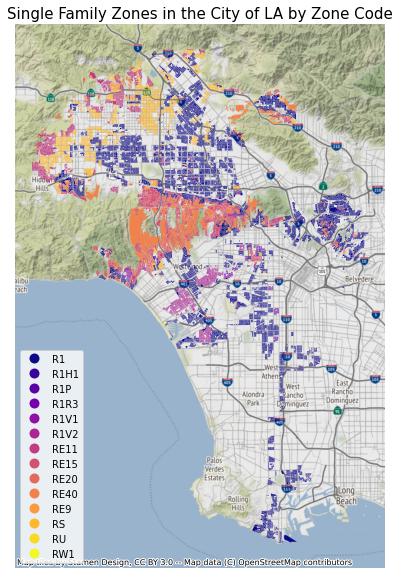

In [19]:
ax = single_family_wm.plot(
            figsize=(10,10),   
            column = 'ZONE_CLASS',  
            cmap = 'plasma', alpha = 1, legend = True,           
            legend_kwds={
               'loc': 'lower left',
            }        
) 
ax.axis('off')
ax.set_title('Single Family Zones in the City of LA by Zone Code', fontsize=15)
ctx.add_basemap(ax)

Okay, so we can clearly see that different zone codes are prominant in different areas. For example, R1 zoning, our traditional single family zoning, is dispersed throughout the city. It also looks like our various RE zones are located in our mountains. This makes sense since RE classifies single family estates zoning and estates in Los Angeles are known to be concentrated in the hills. 

We also see that although R1 zoning is dispersed throughout the City of LA, RS zoning is mostly found in the north east of the city. This makes sense since RS zoning is known as single family suburban zoning and the north west of the city is the suburbs. However, R1 is still also prominent here. It would be interesting to understand why the city needed to distinguish between R1 and RS zoning. Additionally, it would be interesting to see if there is more or less affordable housing where RS zoning is more prominant than R1 zoning. 

Although this map is great at summarizing our distribution, it is a little hard to see the smaller zones and zone classes. Thus, we use a function and a loop to map each zone class separately. 

## 7. Converting original gdf to webmercator

We want to run a spatial autocorellation analysis to analyse the concentration of single family zones in Los Angeles. However, before we do that, we should also converty our original gdf to webmerecator. 

In [20]:
gdf.crs
gdf_wm = gdf.to_crs(epsg=3857)

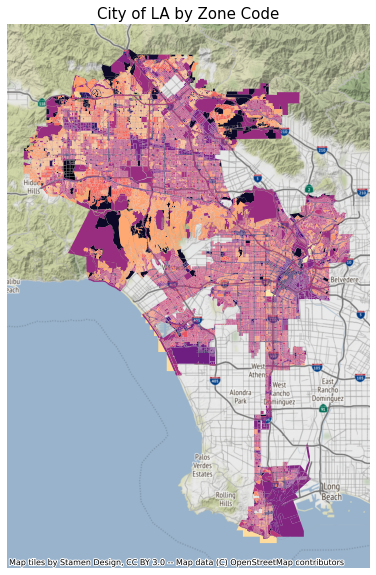

In [21]:
ax = gdf_wm.plot(
            figsize=(10,10),   
            column = 'ZONE_CLASS',  
            cmap = 'magma', alpha = 1, legend = False,           
            legend_kwds={
               'loc': 'lower left',
            }        
) 
ax.axis('off')
ax.set_title('City of LA by Zone Code', fontsize=15)
ctx.add_basemap(ax)

## 8. Adding the LA Times Neighborhood Overlay

Now that our single family data and our original zoning data are compatibl with webmercator, we should add our LA Times Neighborhood overlay so that we have boundaries to run our spatial autocorellation on. We will use the same process we have used for our other data sources.

In [22]:
Neighborhood_Boundaries = gpd.read_file('Data/LA_Times_Neighborhood_Boundaries.zip')

In [23]:
Neighborhood_Boundaries.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   OBJECTID  114 non-null    int64   
 1   name      114 non-null    object  
 2   geometry  114 non-null    geometry
dtypes: geometry(1), int64(1), object(1)
memory usage: 2.8+ KB


In [24]:
Neighborhood_Boundaries.sample(5)

,OBJECTID,name,geometry
47,48,Hollywood Hills,"POLYGON ((-118.31783 34.15212, -118.31663 34.1..."
34,35,Glassell Park,"POLYGON ((-118.22967 34.13488, -118.22966 34.1..."
19,20,Cheviot Hills,"POLYGON ((-118.39888 34.04426, -118.39879 34.0..."
16,17,Chatsworth,"MULTIPOLYGON (((-118.66275 34.21290, -118.6627..."
104,105,Westchester,"POLYGON ((-118.35862 33.98240, -118.35856 33.9..."


In [25]:
columns_to_keep_2 = ['name',
                     'geometry']

In [26]:
Neighborhood_Boundaries = Neighborhood_Boundaries[columns_to_keep_2]

In [27]:
Neighborhood_Boundaries.sample(5)

,name,geometry
18,Chesterfield Square,"POLYGON ((-118.30898 33.97458, -118.30898 33.9..."
77,Rancho Park,"POLYGON ((-118.41484 34.03232, -118.41235 34.0..."
54,Larchmont,"POLYGON ((-118.31360 34.07624, -118.32063 34.0..."
68,Pacific Palisades,"POLYGON ((-118.55703 34.12653, -118.55669 34.1..."
111,Winnetka,"POLYGON ((-118.56232 34.23199, -118.56232 34.2..."


<AxesSubplot:>

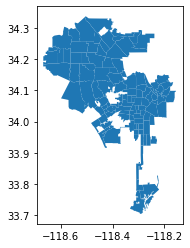

In [28]:
Neighborhood_Boundaries.plot()

In [29]:
Neighborhood_Boundaries = Neighborhood_Boundaries.to_crs(epsg=3857)

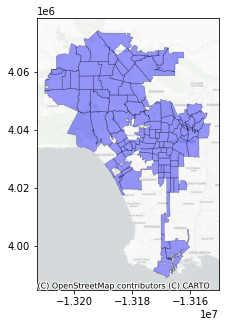

In [30]:
fig, ax = plt.subplots(figsize=(5,5))

Neighborhood_Boundaries.plot(ax=ax,
         color='blue', 
         edgecolor='black',
         lw=0.5,
         alpha=0.4)

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

## 9. Merging Data

We then overlayed zoning data on top of the neighborhood dataset

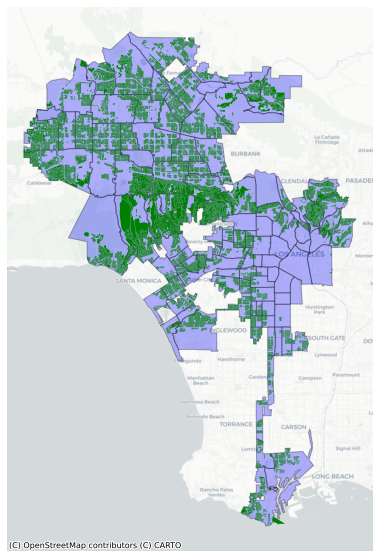

In [31]:
fig, ax = plt.subplots(figsize=(10, 10))

Neighborhood_Boundaries.plot(ax=ax,
        color='blue', 
        edgecolor='black',
        alpha=0.3)

single_family_wm.plot(ax=ax,
            color='green',
            markersize=10,
            alpha=1)


ax.axis('off')

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

Now lets combine our single family data with our neighborhood boundaries.

In [32]:
Combined_Data = gpd.sjoin(single_family_wm, Neighborhood_Boundaries,how='left')

Combined_Data.head(3)

,OBJECTID,ZONE_CMPLT,ZONE_CLASS,ZONE_SMRY,SHAPE_Length,SHAPE_Area,geometry,index_right,name
13,14,(F)RE11-1,RE11,RESIDENTIAL,0.002197,2.039770e-07,"POLYGON ((-13187551.946 4071873.482, -13187480...",89.0,Sylmar
14,15,(F)RE11-1,RE11,RESIDENTIAL,0.002240,2.223388e-07,"POLYGON ((-13187622.185 4071939.156, -13187551...",89.0,Sylmar
292,293,R1-1,R1,RESIDENTIAL,0.002181,2.471552e-07,"POLYGON ((-13197795.161 4056692.414, -13197760...",78.0,Reseda


Now we combine our original total zoning data with our neighborhood boundaries. This will allow us to count the total number of zones in dataset so that we can calculate the percentage of single family zones to total zones in each neighborhood to run our spatial autocorrelation.

In [33]:
All_Data = gpd.sjoin(gdf_wm, Neighborhood_Boundaries,how='left')

All_Data.head(3)

,OBJECTID,ZONE_CMPLT,ZONE_CLASS,ZONE_SMRY,SHAPE_Length,SHAPE_Area,geometry,index_right,name
0,1,(F)CM-1-CUGU,CM,INDUSTRIAL,0.001376,1.135955e-07,"POLYGON ((-13178884.952 4059542.772, -13178885...",88.0,Sun Valley
1,2,(F)CM-1-CUGU,CM,INDUSTRIAL,0.001376,1.136063e-07,"POLYGON ((-13178885.596 4059672.254, -13178885...",88.0,Sun Valley
2,3,(F)CM-1-CUGU,CM,INDUSTRIAL,0.001102,5.680651e-08,"POLYGON ((-13178885.965 4059746.248, -13178886...",88.0,Sun Valley


## 10. Calculating The Proportion of Single Family Zones in Each Neighborhood

We then identified which neighborhoods had the highest percentage/proportion of single family zones to total zones.

First we count the number of single family zones in each neighborhood. 

In [34]:
Zones_By_Neighborhood = Combined_Data.name.value_counts().rename_axis('name').reset_index(name='single family zones')

In [35]:
Zones_By_Neighborhood

,name,single family zones
0,Granada Hills,669
1,Woodland Hills,617
2,Sherman Oaks,572
3,Sylmar,553
4,Reseda,550
...,...,...
102,Chatsworth Reservoir,5
103,Sepulveda Basin,5
104,East Hollywood,3
105,Westlake,3


Up top we see the 5 neighborhoods with the most and least single family zones, but we want to normalize this data. Thus, we will now count the number of total zones in each neighborhood to then calculate the percentages.

In [36]:
Total_By_Neighborhood=All_Data.name.value_counts().rename_axis('name').reset_index(name='total zones')

In [37]:
Total_By_Neighborhood

,name,total zones
0,Van Nuys,1563
1,San Pedro,1547
2,Sun Valley,1388
3,Northridge,1288
4,Woodland Hills,1258
...,...,...
109,Elysian Park,81
110,Griffith Park,54
111,Sepulveda Basin,35
112,Hansen Dam,21


Lets add our counts (both single family and total) to our neighborhood boundaries data.

In [38]:
Neighborhood_Boundaries=Neighborhood_Boundaries.merge(Zones_By_Neighborhood,on='name')

In [39]:
Neighborhood_Boundaries.sample(10)

,name,geometry,single family zones
99,Westlake,"POLYGON ((-13164540.588 4036040.952, -13164624...",3
98,West Hills,"POLYGON ((-13202909.531 4060163.064, -13202825...",540
74,San Pedro,"MULTIPOLYGON (((-13167809.778 3995868.770, -13...",491
69,Playa del Rey,"POLYGON ((-13183272.361 4024447.140, -13183185...",71
24,El Sereno,"POLYGON ((-13155515.694 4042067.155, -13155515...",262
7,Beverly Grove,"POLYGON ((-13177167.561 4040928.302, -13177166...",58
19,Cypress Park,"POLYGON ((-13160082.354 4040761.894, -13159992...",47
72,Rancho Park,"POLYGON ((-13181880.160 4033142.080, -13181602...",80
41,Harvard Park,"POLYGON ((-13169970.419 4025387.888, -13170095...",77
35,Griffith Park,"POLYGON ((-13169116.457 4050025.406, -13168966...",19


In [40]:
Neighborhood_Boundaries=Neighborhood_Boundaries.merge(Total_By_Neighborhood,on='name')

In [41]:
Neighborhood_Boundaries.head(10)

,name,geometry,single family zones,total zones
0,Adams-Normandie,"POLYGON ((-13169172.148 4033813.466, -13169528...",36,228
1,Arleta,"POLYGON ((-13184963.897 4064322.573, -13184947...",292,476
2,Arlington Heights,"POLYGON ((-13171168.886 4035928.895, -13170957...",25,238
3,Atwater Village,"MULTIPOLYGON (((-13166742.025 4049392.844, -13...",89,223
4,Baldwin Hills/Crenshaw,"POLYGON ((-13175888.722 4032201.832, -13175804...",102,268
5,Bel-Air,"POLYGON ((-13187090.248 4046375.305, -13186992...",125,169
6,Beverly Crest,"POLYGON ((-13183466.687 4039441.999, -13183487...",317,408
7,Beverly Grove,"POLYGON ((-13177167.561 4040928.302, -13177166...",58,444
8,Beverlywood,"POLYGON ((-13178679.451 4035081.028, -13179041...",65,93
9,Boyle Heights,"POLYGON ((-13157143.296 4036964.855, -13157140...",10,1223


Now let's calculate the percentage of single family zones in each neighborhood by dividing the number of single family zones by total zones and multiplying by 100. 

In [42]:
Neighborhood_Boundaries['percent_single_family'] = Neighborhood_Boundaries['single family zones']/Neighborhood_Boundaries['total zones']*100


In [43]:
Neighborhood_Boundaries.sort_values(by="percent_single_family").tail()

,name,geometry,single family zones,total zones,percent_single_family
64,Pacific Palisades,"POLYGON ((-13197708.571 4045804.708, -13197670...",437,575,76.000000
18,Cheviot Hills,"POLYGON ((-13180103.278 4034746.726, -13180092...",109,141,77.304965
6,Beverly Crest,"POLYGON ((-13183466.687 4039441.999, -13183487...",317,408,77.696078
44,Hollywood Hills West,"POLYGON ((-13176838.996 4046166.777, -13176835...",302,355,85.070423
60,Mount Washington,"POLYGON ((-13159473.436 4044425.068, -13159307...",217,255,85.098039


## 11. Mapping our Normalized Data

I then mapped the 20 neighborhoods with the most single family zones and the 20 neighborhoods with the least.

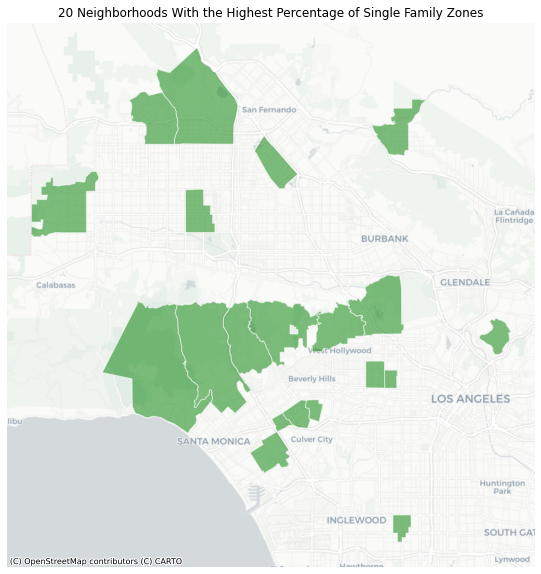

In [44]:
fig,ax = plt.subplots(figsize=(12,10))
Neighborhood_Boundaries.sort_values(by='percent_single_family',ascending=False)[:20].plot(ax=ax,
                                                                 color='green',
                                                                 edgecolor='white',
                                                                 alpha=0.5,legend=True)


# title
ax.set_title('20 Neighborhoods With the Highest Percentage of Single Family Zones')

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

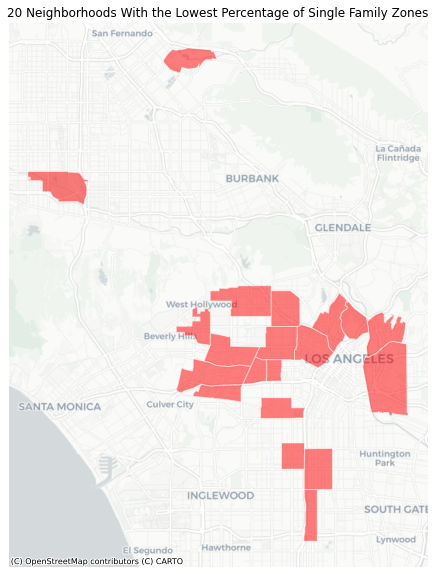

In [45]:
fig,ax = plt.subplots(figsize=(12,10))
Neighborhood_Boundaries.sort_values(by='percent_single_family',ascending=True)[:20].plot(ax=ax,
                                                                 color='red',
                                                                 edgecolor='white',
                                                                 alpha=0.5,legend=True)


# title
ax.set_title('20 Neighborhoods With the Lowest Percentage of Single Family Zones')

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

We made a chloropleth map to show the relationship that neighborhoods with the largest and smallest percentages of single family zones.

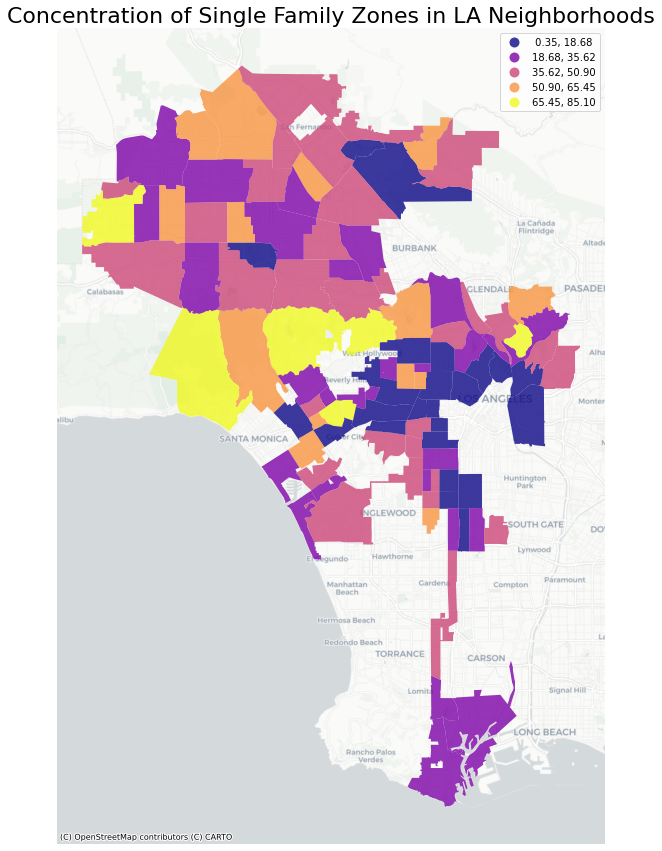

In [46]:
fig,ax = plt.subplots(figsize=(15,15))

Neighborhood_Boundaries.plot(ax=ax,
        column='percent_single_family',
        legend=True,
        alpha=0.8,
        cmap='plasma',
        scheme='natural_breaks')

ax.axis('off')
ax.set_title('Concentration of Single Family Zones in LA Neighborhoods',fontsize=22)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

As expected we see the highest number of single family zones in suburban LA and the lowest number of single family zones in urban LA. For the final, we will overlay this data with affordability indicators. 

## 12. Global Spacial Autocorrelation

Now that we have combined all our data and found our normalized proportions, we can run our global spacial autocrrelation analysis. Let's add our spatial weights and caluculate our spatial lags.

In [47]:
# calculate spatial weight
wq =  lps.weights.KNN.from_dataframe(Neighborhood_Boundaries,k=8)

# Row-standardization
wq.transform = 'r'

### Spatial Lag

In [48]:
# create a new column for the spatial lag
Neighborhood_Boundaries['percent_single_family_lag'] = lps.weights.lag_spatial(wq, Neighborhood_Boundaries['percent_single_family'])

In [49]:
Neighborhood_Boundaries.sample(10)

,name,geometry,single family zones,total zones,percent_single_family,percent_single_family_lag
104,Winnetka,"POLYGON ((-13198296.784 4059995.566, -13198296...",481,867,55.478662,44.162018
95,Watts,"POLYGON ((-13162887.047 4022598.549, -13162887...",171,415,41.204819,26.461863
53,Los Feliz,"POLYGON ((-13166114.647 4044713.084, -13165953...",163,390,41.794872,25.559364
81,Sunland,"POLYGON ((-13169030.218 4065953.802, -13169044...",190,339,56.047198,36.566072
32,Gramercy Park,"POLYGON ((-13169140.859 4022092.530, -13169177...",136,216,62.962963,29.803711
31,Glassell Park,"POLYGON ((-13161266.571 4046927.642, -13161265...",175,377,46.419098,38.123679
57,Mid-Wilshire,"POLYGON ((-13171651.434 4036146.903, -13172069...",82,565,14.513274,29.092692
25,Elysian Park,"POLYGON ((-13162690.236 4041418.538, -13162480...",10,81,12.345679,29.459340
55,Mar Vista,"POLYGON ((-13182612.531 4030189.021, -13182464...",301,520,57.884615,38.572231
38,Harbor City,"POLYGON ((-13168986.657 4002454.311, -13168987...",80,399,20.050125,34.665393


The spatial lag is a "a calculated assignment to each geography in your data, which takes into account the data values from others in their  "neighborhood" as defined by the spatial weight."

### The donut and the diamond

In [50]:
# a column that calculates the difference betwen single family zones and lag
Neighborhood_Boundaries['single_family_diff'] = Neighborhood_Boundaries['percent_single_family'] - Neighborhood_Boundaries['percent_single_family_lag']

In [51]:
Neighborhood_Boundaries.sort_values(by='single_family_diff')

,name,geometry,single family zones,total zones,percent_single_family,percent_single_family_lag,single_family_diff
45,Hollywood,"POLYGON ((-13172214.733 4042970.573, -13172087...",53,893,5.935050,46.367305,-40.432255
37,Hansen Dam,"POLYGON ((-13176001.157 4065549.259, -13175893...",1,21,4.761905,43.511095,-38.749190
66,Palms,"POLYGON ((-13178931.084 4032762.480, -13178866...",79,423,18.676123,47.161366,-28.485243
7,Beverly Grove,"POLYGON ((-13177167.561 4040928.302, -13177166...",58,444,13.063063,41.147861,-28.084798
22,East Hollywood,"POLYGON ((-13167693.603 4042017.145, -13167693...",3,555,0.540541,28.335869,-27.795329
...,...,...,...,...,...,...,...
98,West Hills,"POLYGON ((-13202909.531 4060163.064, -13202825...",540,731,73.871409,38.283083,35.588326
18,Cheviot Hills,"POLYGON ((-13180103.278 4034746.726, -13180092...",109,141,77.304965,36.721869,40.583096
44,Hollywood Hills West,"POLYGON ((-13176838.996 4046166.777, -13176835...",302,355,85.070423,42.300725,42.769697
103,Windsor Square,"POLYGON ((-13170658.597 4037203.367, -13170676...",72,110,65.454545,16.373147,49.081398


In [52]:
# the neighborhood with highest negative difference
gdf_donut = Neighborhood_Boundaries.sort_values(by='single_family_diff').head(1)
gdf_donut

,name,geometry,single family zones,total zones,percent_single_family,percent_single_family_lag,single_family_diff
45,Hollywood,"POLYGON ((-13172214.733 4042970.573, -13172087...",53,893,5.93505,46.367305,-40.432255


Our Donut is Hollywood. This means that Hollywood has a low percentage of single family zones but is surrounded by neighborhoods with a high percentage of single family zones. This makes a lot of sense. Hollywood is generally a tourist neighborhood with a lot of commercial and industrial buildings. When you drive through Hollywood you mostly see multifamily homes. However, Hollywood is also adjacent to neighborhoods inn the Hollywood Hills that are almostt completely single family zones and Hancock Park which is clustered with large single family mansions.

In [53]:
# the neighborhood with highest positive difference
gdf_diamond = Neighborhood_Boundaries.sort_values(by='single_family_diff').tail(1)
gdf_diamond

,name,geometry,single family zones,total zones,percent_single_family,percent_single_family_lag,single_family_diff
60,Mount Washington,"POLYGON ((-13159473.436 4044425.068, -13159307...",217,255,85.098039,33.371429,51.72661


Our Diamond is Mount Washington which means Mount Washington has a high concentration of single family zones but is surrounded by neighborhoods with a low concentration of single family zones. This also makes sense given the history and location of redlining in Los Angeles. As a quick summary of it all, during redlining in the 30s and 40s Mount Washington was considered the sole "desirable" neighborhood surrounded by many "undersirable" (yellow) and "hazardous" (red) neighborhoods such as Lincoln Heights and Montecito Heights. Historically, redlined neighoborhoods remained urban with very few single family zones and homes while desirable neighborhoods (like Mount Washington) were suburban with a high concentration of single family zones. Our data is literally showing us the legacy redlining still has on the city nearly 80 years later. 

We also went ahead and mapped our donut (in red) and diamond (in green) below.

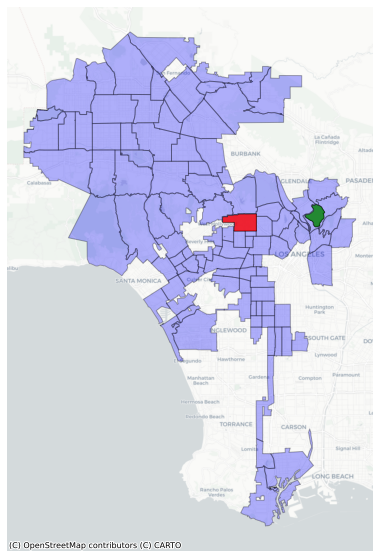

In [54]:
fig, ax = plt.subplots(figsize=(10, 10))

Neighborhood_Boundaries.plot(ax=ax,
        color='blue', 
        edgecolor='black',
        alpha=0.3)

gdf_diamond.plot(ax=ax,
         color='green', 
         edgecolor='black',
         lw=0.5,
         alpha=0.8)

gdf_donut.plot(ax=ax,
         color='red', 
         edgecolor='black',
         lw=0.5,
         alpha=0.8)

ax.axis('off')

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

### Morans Plot

Now we use a Morans Plot to quantify the degree of spatial correlations of single family homes and neighborhoods. To begin this process, we test for global autocorrelation for a continuous attribute (single family zones).

In [55]:
y = Neighborhood_Boundaries.percent_single_family
moran = Moran(y, wq)
moran.I

0.1277824563686716

Our Moron value is roughly .13. This really only tells us the slope of our Moran scatterplot (pictured below). However, a positive slope tells us there is a positive correlation. To truly understand whether or not the location of single family zones is radomized, we need the p-value. Which we find using the next 3 codes.

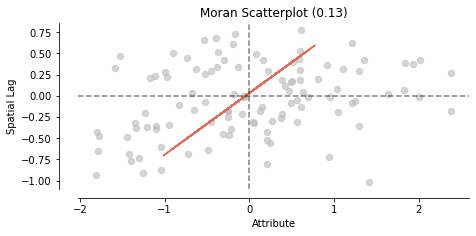

In [56]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Reference Distribution'}, xlabel='Moran I: 0.13', ylabel='Density'>)

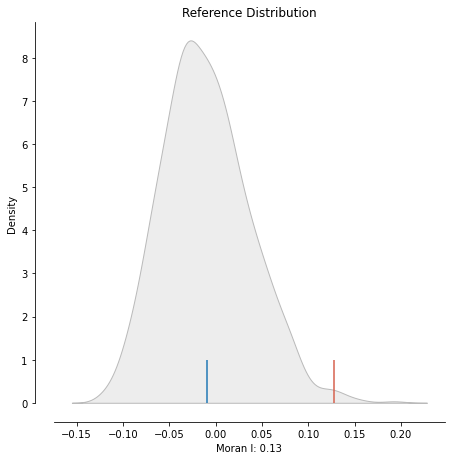

In [57]:
plot_moran_simulation(moran,aspect_equal=False)

Now let's calculate our p-value! 

In [58]:
moran.p_sim

0.007

A p-value of 0.004 is extremely low. In simplified terms a p-value this low allows us to reject the notion (null hypothesis) that the location of single family zoning througout LA is random.

In more complecated terms:
The value is calculated as an empirical P-value that represents the proportion of realisations in the simulation under spatial randomness that are more extreme than the observed value. A small enough p-value associated with the Moran’s I of a map allows to reject the hypothesis that the map is random. In other words, we can conclude that the map displays more spatial pattern than we would expect if the values had been randomly allocated to a locations.

If we generated a large number of maps with the same values but randomly allocated over space, and calculated the Moran’s I statistic for each of those maps, only 0.4% of them would display a larger (absolute) value than the one we obtain from the observed data, and the other 99.6% of the random maps would receive a smaller (absolute) value of Moran’s I. 

## 13. Local Spatial Autocorrelation

So far, we have only determined that there is a positive spatial autocorrelation between the concentration of single family zones in LA city and their locations. But we have not detected where clusters are. Local Indicators of Spatial Association (LISA) is used to do that. LISA classifies areas into four groups: high values near to high values (HH), Low values with nearby low values (LL), Low values with high values in its neighborhood, and vice-versa.

- HH: high single family zone concentration near other high single family zone concentration
- LL: low single family zone concentrationnear other low single family zone concentration
- LH (donuts): low single family zone concentration surrounded by high single family zone concentration
- HL (diamonds): high single family zone concentration surrounded by single family zone concentration

In [59]:
# calculate local moran values
lisa = esda.moran.Moran_Local(y, wq)

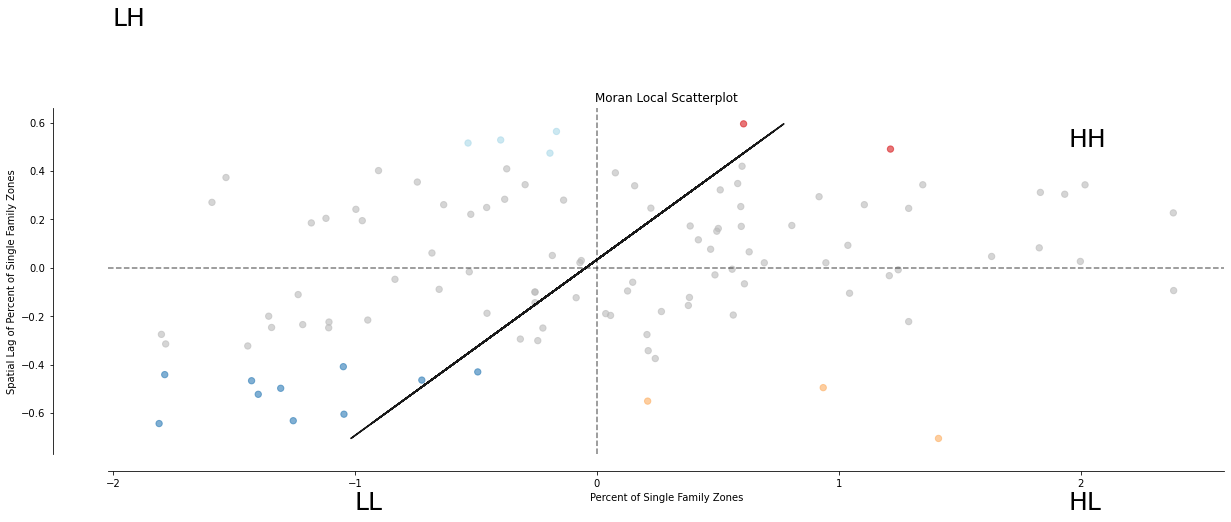

In [60]:
# Plot
fig,ax = plt.subplots(figsize=(20,15))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("Percent of Single Family Zones")
ax.set_ylabel('Spatial Lag of Percent of Single Family Zones')

# add some labels
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

In the scatterplot above, the colored dots represents the rows (neighborhoods) that have a P-value less that 0.05 in each quadrant. In other words, these are the statisticaly significantly, spatially autocorrelated geographies.

### Spatial Autocorrelation Map
Finally, you can visually these statistically significant clusters using the `lisa_cluster` function:

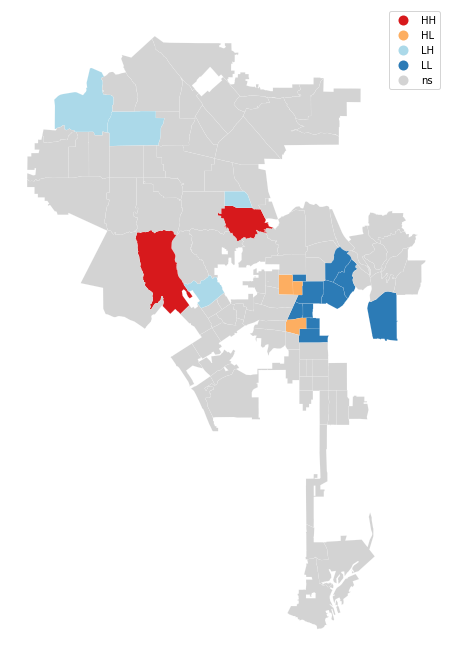

In [61]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, Neighborhood_Boundaries, p=0.05, ax=ax)
plt.show()

Our HH (high near high) is in the mountains (known for single family zoning) and our LL is clustured near urban Downtown LA and where historically redlined. 

And create a map comparing different p-values

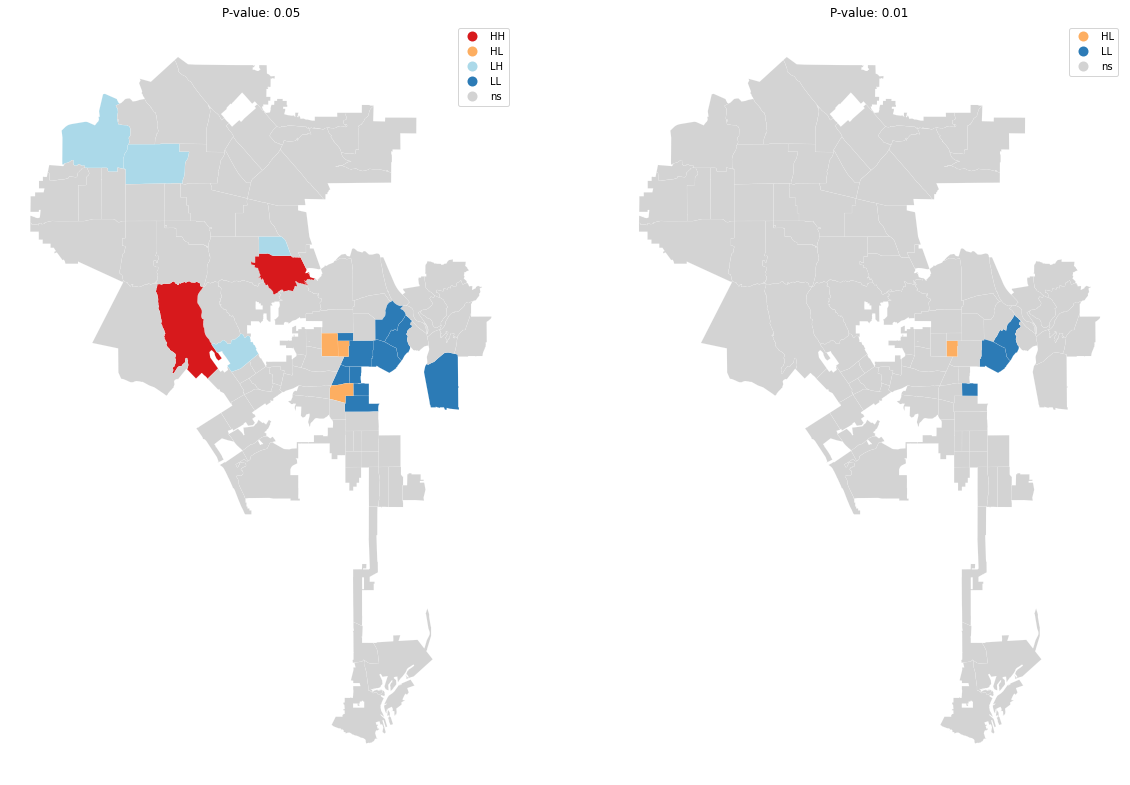

In [62]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 20))

# regular count map on the left
lisa_cluster(lisa, Neighborhood_Boundaries, p=0.05, ax=ax[0])

ax[0].axis("off")
ax[0].set_title("P-value: 0.05")

# spatial lag map on the right
lisa_cluster(lisa, Neighborhood_Boundaries, p=0.01, ax=ax[1])
ax[1].axis("off")
ax[1].set_title("P-value: 0.01")

plt.show()

Trong and Sharon worked on this notebook equally. Thank you!